# Quality control

Key scientific variables supplied via the VOTO ERDDAP come with pre-computed quality control flags. These flags are not applied by default. This notebook covers how to examine the flags and apply them to the data. It also demonstrates how to examine the flag metadata to see the tests and thresholds applied, and how to re-run the flagging process with your own flagging routines

In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

## 1. Download data

In [6]:
datasets_to_download = ['delayed_SEA066_M41', 'nrt_SEA061_M39']
ds_dict = utils.download_glider_dataset(datasets_to_download, nrt_only=False)

Writing voto_erddap_data_cache/delayed_SEA066_M41.nc


In [7]:
ds = ds_dict["delayed_SEA066_M41"]
ds

<xarray.Dataset>
Dimensions:                   (obs: 2330157)
Coordinates:
    latitude                  (obs) float64 ...
    longitude                 (obs) float64 ...
    time                      (obs) datetime64[ns] ...
    depth                     (obs) float64 ...
Dimensions without coordinates: obs
Data variables: (12/44)
    ad2cp_beam1_cell_number1  (obs) float64 ...
    ad2cp_beam2_cell_number1  (obs) float64 ...
    ad2cp_beam3_cell_number1  (obs) float64 ...
    ad2cp_beam4_cell_number1  (obs) float64 ...
    ad2cp_heading             (obs) float64 ...
    ad2cp_pitch               (obs) float64 ...
    ...                        ...
    voltage                   (obs) float64 ...
    distance_over_ground      (obs) float64 ...
    profile_direction         (obs) float64 ...
    potential_density         (obs) float64 ...
    density                   (obs) float64 ...
    potential_temperature     (obs) float64 ...
Attributes: (12/76)
    acknowledgement:               This study used data collected and made fr...
    AD2CP:                         {'calibration_date': '2022-03-17', 'factor...
    basin:                         Eastern Gotland Basin
    cdm_data_type:                 TimeSeries
    cdm_timeseries_variables:      profile_index
    comment:                       deployment and recovery in Skagerrak
    ...                            ...
    title:                         Saltarv66-20220727T1334
    total_dives:                   1174.0
    transmission_system:           IRIDIUM
    variables:                     keep_variables\ntime\nlatitude\nlongitude\...
    Westernmost_Easting:           19.51033333333333
    wmo_id:                        6801505

## 2. Examine flags

Flags, where avaiable, are named `<variable-name>_qc`. Let's take a look at some salinity flags

In [4]:
ds["salinity_qc"]

<xarray.DataArray 'salinity_qc' (obs: 13071)>
array([4., 4., 4., ..., 1., 1., 1.])
Coordinates:
    latitude   (obs) float64 ...
    longitude  (obs) float64 ...
    time       (obs) datetime64[ns] ...
    depth      (obs) float64 ...
Dimensions without coordinates: obs
Attributes:
    actual_range:                 [1. 4.]
    colorBarMaximum:              10.0
    colorBarMinimum:              0.0
    comment:                      Quality control flags from IOOS QC QARTOD h...
    flag_meanings:                GOOD, UNKNOWN, SUSPECT, FAIL, MISSING
    flag_values:                  [1. 2. 3. 4. 9.]
    ioos_category:                Quality
    ioos_qc_module:               qartod
    long_name:                    quality control flags for water salinity
    quality_control_conventions:  IOOS QARTOD standard flags
    quality_control_set:          1.0
    standard_name:                sea_water_practical_salinity_flag
    valid_max:                    9.0
    valid_min:                    1.0

In [5]:
qc_vals_present = np.unique(ds["salinity_qc"])
print(qc_vals_present)

[1. 3. 4.]


We see that the flag is an array of integers, with the same shape as the salinity variable, so that each salinity observation has a corresponding flag value. Information about the flags in stored in the `attributes`

In [9]:
ds["salinity_qc"].attrs

{'actual_range': array([1., 4.]),
 'colorBarMaximum': 10.0,
 'colorBarMinimum': 0.0,
 'comment': 'Quality control flags from IOOS QC QARTOD https://github.com/ioos/ioos_qc Version: 2.1.0. Using config: [<Call stream_id=conductivity function=qartod.gross_range_test(suspect_span=[6, 42], fail_span=[3, 45])>, <Call stream_id=salinity function=qartod.gross_range_test(suspect_span=[5, 38], fail_span=[2, 41])>, <Call stream_id=salinity function=qartod.spike_test(suspect_threshold=0.3, fail_threshold=0.9)>, <Call stream_id=salinity function=qartod.location_test(bbox=[10, 50, 25, 60])>].  Threshold values from EuroGOOS DATA-MEQ Working Group (2010) Recommendations for in-situ data Near Real Time Quality Control [Version 1.2]. EuroGOOS, 23pp. DOI https://dx.doi.org/10.25607/OBP-214.',
 'flag_meanings': 'GOOD, UNKNOWN, SUSPECT, FAIL, MISSING',
 'flag_values': array([1., 2., 3., 4., 9.]),
 'ioos_category': 'Quality',
 'ioos_qc_module': 'qartod',
 'long_name': 'quality control flags for water sali

The most important pieces of metadata are `flag_values` and `flag_meanings`. This tells us that flag values of

`[1., 2., 3., 4., 9.]`

Correspond to flag meanings of 

`'GOOD, UNKNOWN, SUSPECT, FAIL, MISSING'`

From this we can interperet that the first few values for salinity are flagged 4 which means FAIL. this is common for glider salinity data just after the glider is deployed. It will be sitting at the surface with no water flowing through the CT sail.

Let's take a closer look at these flags.

In [30]:
attrs = ds["salinity_qc"].attrs
flag_vals = attrs["flag_values"]
flag_meanings = attrs["flag_meanings"].split(", ")
df = pd.DataFrame({"time":ds.time, "depth":ds.depth, "salinity":ds.salinity, "salinity_qc": ds.salinity_qc})


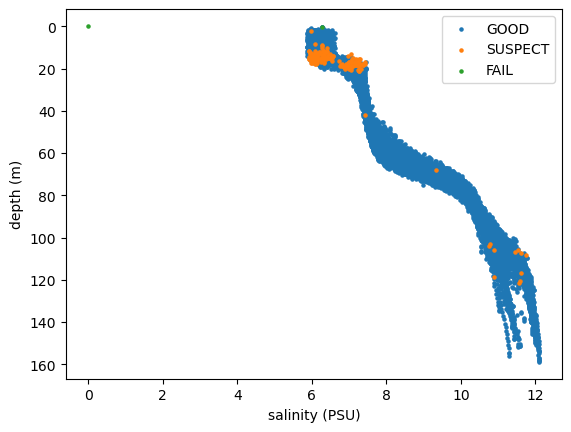

In [31]:
df = pd.DataFrame({"time":ds.time, "depth":ds.depth, "salinity":ds.salinity, "salinity_qc": ds.salinity_qc})

fig, ax = plt.subplots()
for val, meaning in zip(flag_vals, flag_meanings):
    if val not in np.unique(ds["salinity_qc"]):
        continue
    df_sub = df[df["salinity_qc"]==val]
    ax.scatter(df_sub.salinity, df_sub.depth, label=meaning, s=5)

ax.set(ylabel="depth (m)", xlabel="salinity (PSU)")
ax.legend()
ax.invert_yaxis()
    

In [6]:
import plotly.express as px
import plotly.graph_objects as go

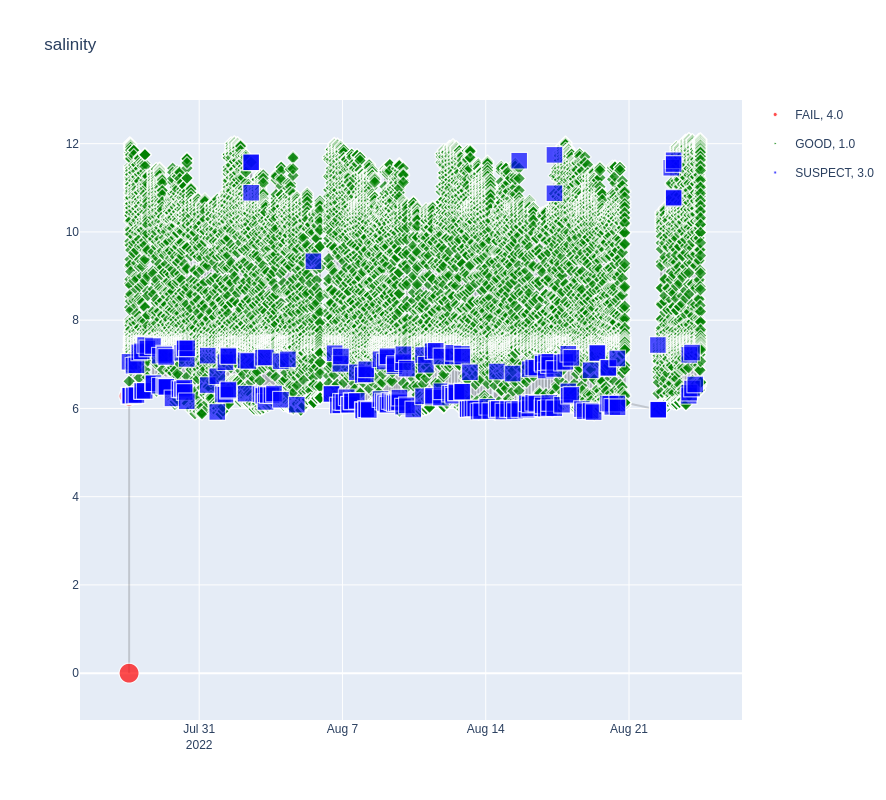

In [31]:
var_name = "salinity_qc"
time = ds.time
flag = ds[var_name]
var = var_name[:-3]
data = ds[var]
meaning = np.empty(len(time), dtype=object)
meaning[:] = "UNKNOWN"
meaning[flag == 1] = "GOOD"
meaning[flag == 9] = "MISSING"
meaning[flag == 3] = "SUSPECT"
meaning[flag == 4] = "FAIL"
df = pd.DataFrame({"time": time, var: data, "flag": flag, "depth": ds.depth, "quality control": meaning})
fig1 = px.line(df, x="time", y=var)
fig1.update_traces(line=dict(color='rgba(50,50,50,0.2)'))
fig2 = px.scatter(df, x="time", y=var, color="quality control", size="flag",
                  hover_data=['quality control'], symbol="flag",
                  color_discrete_sequence=["red", "green", "blue"], )

fig3 = go.Figure(data=fig1.data + fig2.data, layout={"height":800, "title":var, })
fig3.show()

We see FAIL flags at the begininning of the deployment when salinity is 0, and most SUSPECT flags are at the surface or on the thermocline.

## 3. Apply flags

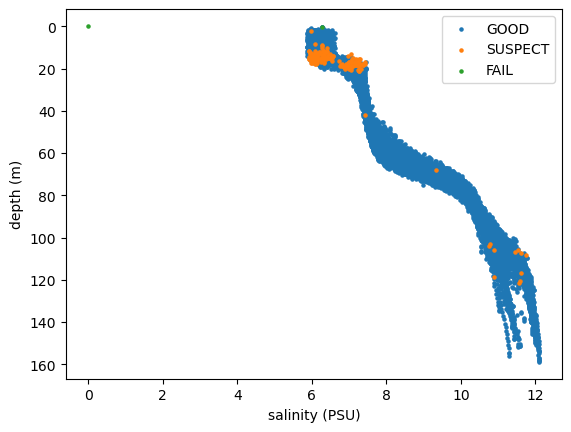

In [32]:
df = pd.DataFrame({"time":ds.time, "depth":ds.depth, "salinity":ds.salinity, "salinity_qc": ds.salinity_qc})

fig, ax = plt.subplots()
for val, meaning in zip(flag_vals, flag_meanings):
    if val not in np.unique(ds["salinity_qc"]):
        continue
    df_sub = df[df["salinity_qc"]==val]
    ax.scatter(df_sub.salinity, df_sub.depth, label=meaning, s=5)

ax.set(ylabel="depth (m)", xlabel="salinity (PSU)")
ax.legend()
ax.invert_yaxis()

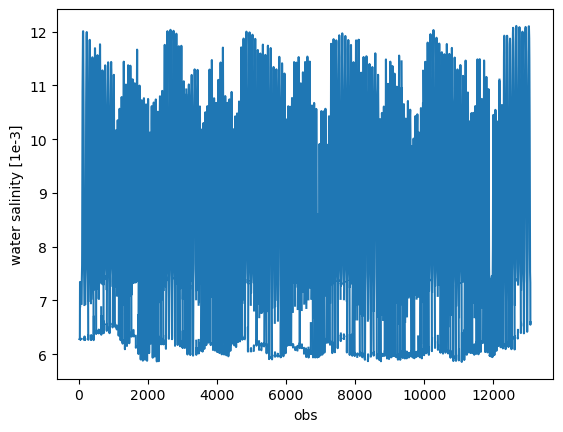

In [36]:
ds["salinity_flagged"] = ds["salinity"].copy()
ds["salinity_flagged"][ds["salinity_qc"]>2] = np.nan
ds.salinity_flagged.plot()

----------------------------------
### Oxygen

We experienced some issues with early oxygen sensors. As such, many datasets from before 2022-06 have oxygen flags with a minimum value of 3